Loan word classification experiments

In [1]:
import sklearn as sk
from sklearn.linear_model import LogisticRegression
import pandas as pd 
import numpy as np 
import io
import requests
import csv
import json
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import pprint
import matplotlib.pyplot as plt
import random

In [2]:
import torch
from torch import nn
from torch import optim
from sklearn.model_selection import train_test_split

/usr/local/Caskroom/miniforge/base/envs/mt/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [4]:
pairs = None

with open('../language-pairs.json', 'r') as f:
    pairs = json.loads(f.read())
    
train_alldata = {}
test_alldata = {}

train_realdist = {}
test_realdist = {}

train_balanced = {}
test_balanced = {}

for pair in pairs:
    print(pair)
    L1 = pairs[pair]['target']['name']
    L2 = pairs[pair]['source']['name']

    # load datasets
    prefix = f'../Datasets/production_train_test/{L1}-{L2}'

    train_alldata[f'{L1}-{L2}'] = pd.read_csv(f'{prefix}/alldata/{L1}-{L2}-train_production_alldata.csv')
    test_alldata[f'{L1}-{L2}'] = pd.read_csv(f'{prefix}/alldata/{L1}-{L2}-test_production_alldata.csv')

    train_realdist[f'{L1}-{L2}'] = pd.read_csv(f'{prefix}/realdist/{L1}-{L2}-train_production_realdist.csv')
    test_realdist[f'{L1}-{L2}'] = pd.read_csv(f'{prefix}/realdist/{L1}-{L2}-test_production_realdist.csv')

    train_balanced[f'{L1}-{L2}'] = pd.read_csv(f'{prefix}/balanced/{L1}-{L2}-train_production_balanced.csv')
    test_balanced[f'{L1}-{L2}'] = pd.read_csv(f'{prefix}/balanced/{L1}-{L2}-test_production_balanced.csv')
    
    
features = ['Fast Levenshtein Distance Div Maxlen',
            'Dolgo Prime Distance Div Maxlen',
            'Feature Edit Distance Div Maxlen',
            'Hamming Feature Distance Div Maxlen',
            'Weighted Feature Distance Div Maxlen',
            'Partial Hamming Feature Distance Div Maxlen',
            'plain Levenshtein',
            'DNN_logits',
            'MBERT_cos_sim',
            'XLM_cos_sim'
           ]

labels = ['label_bin']

train_allpairs_alldata = pd.concat([train_alldata[pair] for pair in pairs])
x_train_allpairs_alldata = np.hstack([train_allpairs_alldata[features].values])
y_train_allpairs_alldata = train_allpairs_alldata[labels].values.ravel()
x_train_allpairs_alldata_means = np.mean(x_train_allpairs_alldata, axis=1).reshape(-1,1)
x_train_allpairs_alldata_stds = np.std(x_train_allpairs_alldata, axis=1).reshape(-1,1)

test_allpairs_alldata = pd.concat([test_alldata[pair] for pair in pairs])
x_test_allpairs_alldata = np.hstack([test_allpairs_alldata[features].values])
y_test_allpairs_alldata = test_allpairs_alldata[labels].values.ravel()

train_allpairs_realdist = pd.concat([train_realdist[pair] for pair in pairs])
x_train_allpairs_realdist = np.hstack([train_allpairs_realdist[features].values])
y_train_allpairs_realdist = train_allpairs_realdist[labels].values.ravel()
x_train_allpairs_realdist_means = np.mean(x_train_allpairs_realdist, axis=1).reshape(-1,1)
x_train_allpairs_realdist_stds = np.std(x_train_allpairs_realdist, axis=1).reshape(-1,1)

test_allpairs_realdist = pd.concat([test_realdist[pair] for pair in pairs])
x_test_allpairs_realdist = np.hstack([test_allpairs_realdist[features].values])
y_test_allpairs_realdist = test_allpairs_realdist[labels].values.ravel()

train_allpairs_balanced = pd.concat([train_balanced[pair] for pair in pairs])
x_train_allpairs_balanced = np.hstack([train_allpairs_balanced[features].values])
y_train_allpairs_balanced = train_allpairs_balanced[labels].values.ravel()
x_train_allpairs_balanced_means = np.mean(x_train_allpairs_balanced, axis=1).reshape(-1,1)
x_train_allpairs_balanced_stds = np.std(x_train_allpairs_balanced, axis=1).reshape(-1,1)

test_allpairs_balanced = pd.concat([test_balanced[pair] for pair in pairs])
x_test_allpairs_balanced = np.hstack([test_allpairs_balanced[features].values])
y_test_allpairs_balanced = test_allpairs_balanced[labels].values.ravel()

Hindi-Persian
English-French


# Logistic Regression classifier

In [5]:
def lr_evaluate(full_train_set, full_test_set, pairs_list):    
    train_set = pd.concat([full_train_set[pair] for pair in pairs])
    x_train = train_set[features].values
    x_means = np.mean(x_train, axis=0)
    x_stds = np.std(x_train, axis=0)
    y_train = train_set[labels].values.ravel()
    
    test_set = pd.concat([full_test_set[pair] for pair in pairs])
    x_test = test_set[features].values
    y_test = test_set[labels].values.ravel()
    
    # standardize input features
    x_train = (x_train - x_means)/x_stds

    print("Training on all langs\n")
    LR = LogisticRegression(random_state=1, solver='lbfgs', multi_class='ovr', max_iter=500).fit(x_train, y_train)

    # display regressor weights
    df = pd.DataFrame(LR.coef_, columns=features).style.set_caption('Weights')
    display(df)
    print()
    
    print("Evaluating on all langs")
    x_test = (x_test - x_means)/x_stds
    y_pred = LR.predict(x_test)

    print("f1-score : ", f1_score(y_test, y_pred ))
    print("precision : ",precision_score(y_test, y_pred))
    print("recall : ",recall_score(y_test, y_pred )) 
    print("accuracy : ",accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print()
    
    # display false positives and false negatives
    unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
    tp = np.array(np.where(unq == 3)).tolist()[0]
    fp = np.array(np.where(unq == 1)).tolist()[0]
    tn = np.array(np.where(unq == 0)).tolist()[0]
    fn = np.array(np.where(unq == 2)).tolist()[0]

    display(test_set.iloc[fp,:].style.set_caption('False positives'))
    display(test_set.iloc[fn,:].style.set_caption('False negatives'))
    
    for pair in pairs_list:
        print(f'Evaluating on {pair}')
        
        test_set = full_test_set[pair]
        x_test = test_set[features].values
        y_test = test_set[labels].values.ravel()
        
        x_test = (x_test - x_means)/x_stds
        y_pred = LR.predict(x_test)
        
        print("f1-score : ", f1_score(y_test, y_pred ))
        print("precision : ",precision_score(y_test, y_pred))
        print("recall : ",recall_score(y_test, y_pred )) 
        print("accuracy : ",accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        print(confusion_matrix(y_test, y_pred))
        print()
        
        # display false positives and false negatives
        unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
        tp = np.array(np.where(unq == 3)).tolist()[0]
        fp = np.array(np.where(unq == 1)).tolist()[0]
        tn = np.array(np.where(unq == 0)).tolist()[0]
        fn = np.array(np.where(unq == 2)).tolist()[0]

        display(test_set.iloc[fp,:].style.set_caption('False positives'))
        display(test_set.iloc[fn,:].style.set_caption('False negatives'))
        
    for pair in pairs_list:
        print(f'Training and evaluating on {pair}')
        
        train_set = full_train_set[pair]
        x_train = train_set[features].values
        x_means = np.mean(x_train, axis=0)
        x_stds = np.std(x_train, axis=0)
        y_train = train_set[labels].values.ravel()
        
        test_set = full_test_set[pair]
        x_test = test_set[features].values
        y_test = test_set[labels].values.ravel()
        
        x_train = (x_train - x_means)/x_stds
        
        LR = LogisticRegression(random_state=1, solver='lbfgs', multi_class='ovr', max_iter=500).fit(x_train, y_train)
        
        # display regressor weights
        df = pd.DataFrame(LR.coef_, columns=features).style.set_caption('Weights')
        display(df)

        x_test = (x_test - x_means)/x_stds
        y_pred = LR.predict(x_test)
        
        print("f1-score : ", f1_score(y_test, y_pred ))
        print("precision : ",precision_score(y_test, y_pred))
        print("recall : ",recall_score(y_test, y_pred )) 
        print("accuracy : ",accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        print(confusion_matrix(y_test, y_pred))
        print()
        
        # display false positives and false negatives
        unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
        tp = np.array(np.where(unq == 3)).tolist()[0]
        fp = np.array(np.where(unq == 1)).tolist()[0]
        tn = np.array(np.where(unq == 0)).tolist()[0]
        fn = np.array(np.where(unq == 2)).tolist()[0]

        display(test_set.iloc[fp,:].style.set_caption('False positives'))
        display(test_set.iloc[fn,:].style.set_caption('False negatives'))

In [6]:
print("Evaluating on alldata splits\n")
lr_evaluate(train_alldata, test_alldata, pairs)

print("Evaluating on realdist splits\n")
lr_evaluate(train_realdist, test_realdist, pairs)

print("Evaluating on balanced splits\n")
lr_evaluate(train_balanced, test_balanced, pairs)

Evaluating on alldata splits

Training on all langs




Evaluating on all langs
f1-score :  0.7396149949341438
precision :  0.776595744680851
recall :  0.7059961315280464
accuracy :  0.9136134453781513
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2458
           1       0.78      0.71      0.74       517

    accuracy                           0.91      2975
   macro avg       0.86      0.83      0.84      2975
weighted avg       0.91      0.91      0.91      2975

[[2353  105]
 [ 152  365]]



Evaluating on Hindi-Persian
f1-score :  0.7603305785123966
precision :  0.8598130841121495
recall :  0.6814814814814815
accuracy :  0.956060606060606
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1185
           1       0.86      0.68      0.76       135

    accuracy                           0.96      1320
   macro avg       0.91      0.83      0.87      1320
weighted avg       0.95      0.96      0.95      1320

[[1170   15]
 [  43   92]]



Evaluating on English-French
f1-score :  0.7328859060402685
precision :  0.7520661157024794
recall :  0.7146596858638743
accuracy :  0.8797583081570997
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1273
           1       0.75      0.71      0.73       382

    accuracy                           0.88      1655
   macro avg       0.83      0.82      0.83      1655
weighted avg       0.88      0.88      0.88      1655

[[1183   90]
 [ 109  273]]



Training and evaluating on Hindi-Persian


f1-score :  0.7657992565055762
precision :  0.7686567164179104
recall :  0.762962962962963
accuracy :  0.9522727272727273
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1185
           1       0.77      0.76      0.77       135

    accuracy                           0.95      1320
   macro avg       0.87      0.87      0.87      1320
weighted avg       0.95      0.95      0.95      1320

[[1154   31]
 [  32  103]]



Training and evaluating on English-French


f1-score :  0.7721691678035472
precision :  0.8062678062678063
recall :  0.7408376963350786
accuracy :  0.8990936555891239
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1273
           1       0.81      0.74      0.77       382

    accuracy                           0.90      1655
   macro avg       0.87      0.84      0.85      1655
weighted avg       0.90      0.90      0.90      1655

[[1205   68]
 [  99  283]]



Evaluating on realdist splits

Training on all langs




Evaluating on all langs
f1-score :  0.8902953586497891
precision :  0.9791183294663574
recall :  0.816247582205029
accuracy :  0.8915537017726799
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       442
           1       0.98      0.82      0.89       517

    accuracy                           0.89       959
   macro avg       0.90      0.90      0.89       959
weighted avg       0.91      0.89      0.89       959

[[433   9]
 [ 95 422]]



Evaluating on Hindi-Persian
f1-score :  0.9047619047619048
precision :  0.9743589743589743
recall :  0.8444444444444444
accuracy :  0.9466666666666667
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       315
           1       0.97      0.84      0.90       135

    accuracy                           0.95       450
   macro avg       0.96      0.92      0.93       450
weighted avg       0.95      0.95      0.95       450

[[312   3]
 [ 21 114]]



Evaluating on English-French
f1-score :  0.8850574712643677
precision :  0.9808917197452229
recall :  0.806282722513089
accuracy :  0.8428290766208252
              precision    recall  f1-score   support

           0       0.62      0.95      0.75       127
           1       0.98      0.81      0.89       382

    accuracy                           0.84       509
   macro avg       0.80      0.88      0.82       509
weighted avg       0.89      0.84      0.85       509

[[121   6]
 [ 74 308]]



Training and evaluating on Hindi-Persian


f1-score :  0.9266409266409267
precision :  0.967741935483871
recall :  0.8888888888888888
accuracy :  0.9577777777777777
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       315
           1       0.97      0.89      0.93       135

    accuracy                           0.96       450
   macro avg       0.96      0.94      0.95       450
weighted avg       0.96      0.96      0.96       450

[[311   4]
 [ 15 120]]



Training and evaluating on English-French


f1-score :  0.8939828080229226
precision :  0.9873417721518988
recall :  0.8167539267015707
accuracy :  0.8546168958742633
              precision    recall  f1-score   support

           0       0.64      0.97      0.77       127
           1       0.99      0.82      0.89       382

    accuracy                           0.85       509
   macro avg       0.81      0.89      0.83       509
weighted avg       0.90      0.85      0.86       509

[[123   4]
 [ 70 312]]



Evaluating on balanced splits

Training on all langs




Evaluating on all langs
f1-score :  0.9102296450939457
precision :  0.9886621315192744
recall :  0.8433268858800773
accuracy :  0.8783592644978784
              precision    recall  f1-score   support

           0       0.70      0.97      0.81       190
           1       0.99      0.84      0.91       517

    accuracy                           0.88       707
   macro avg       0.84      0.91      0.86       707
weighted avg       0.91      0.88      0.88       707

[[185   5]
 [ 81 436]]



Evaluating on Hindi-Persian
f1-score :  0.9206349206349208
precision :  0.9914529914529915
recall :  0.8592592592592593
accuracy :  0.9261992619926199
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       136
           1       0.99      0.86      0.92       135

    accuracy                           0.93       271
   macro avg       0.93      0.93      0.93       271
weighted avg       0.93      0.93      0.93       271

[[135   1]
 [ 19 116]]



Evaluating on English-French
f1-score :  0.9065155807365438
precision :  0.9876543209876543
recall :  0.837696335078534
accuracy :  0.8486238532110092
              precision    recall  f1-score   support

           0       0.45      0.93      0.60        54
           1       0.99      0.84      0.91       382

    accuracy                           0.85       436
   macro avg       0.72      0.88      0.75       436
weighted avg       0.92      0.85      0.87       436

[[ 50   4]
 [ 62 320]]



Training and evaluating on Hindi-Persian


f1-score :  0.9389312977099236
precision :  0.968503937007874
recall :  0.9111111111111111
accuracy :  0.940959409594096
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       136
           1       0.97      0.91      0.94       135

    accuracy                           0.94       271
   macro avg       0.94      0.94      0.94       271
weighted avg       0.94      0.94      0.94       271

[[132   4]
 [ 12 123]]



Training and evaluating on English-French


f1-score :  0.9119318181818181
precision :  0.9968944099378882
recall :  0.8403141361256544
accuracy :  0.8577981651376146
              precision    recall  f1-score   support

           0       0.46      0.98      0.63        54
           1       1.00      0.84      0.91       382

    accuracy                           0.86       436
   macro avg       0.73      0.91      0.77       436
weighted avg       0.93      0.86      0.88       436

[[ 53   1]
 [ 61 321]]



# Neural Network classifier

## Definition

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_features):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
            
        )

    def forward(self, x):
        logits_new = self.linear_relu_stack(x)
        logits  = logits_new
        
        return torch.sigmoid(logits), logits_new
    
    def fit(self, X_train, Y_train, X_val, Y_val, criterion, optimizer, n_epochs=5000):
        train_losses = []
        val_losses = []
        train_accur = []
        val_accur = []

        for epoch in range(n_epochs):
            y_pred, logits = self(X_train.float())

            train_loss = criterion(y_pred, Y_train.float())

            if epoch % (n_epochs // 50) == 0:
                train_acc,_ = self.calculate_accuracy(Y_train, y_pred)

                y_val_pred = self(X_val.float())[0]

                val_loss = criterion(y_val_pred, Y_val.float())

                val_acc, total_corr = self.calculate_accuracy(Y_val, y_val_pred)

                print(f'''epoch {epoch}
                    Train set - loss: {self.round_tensor(train_loss)}, accuracy: {self.round_tensor(train_acc)} 
                    Val set - loss: {self.round_tensor(val_loss)}, accuracy: {self.round_tensor(val_acc)}''')
                
                train_losses.append(train_loss.detach().numpy())
                val_losses.append(val_loss.detach().numpy())

                val_accur.append(val_acc.detach().numpy())
                train_accur.append(train_acc.detach().numpy())

            optimizer.zero_grad()

            train_loss.backward()

            optimizer.step()
            
        return train_losses,val_losses,train_accur,val_accur
    
    def calculate_accuracy(self, y_true, y_pred):
        predicted = y_pred.ge(.5) 
        return ((y_true == predicted).sum().float() / len(y_true), (y_true == predicted).sum())
    
    def round_tensor(self, t, decimal_places=3):
        return round(t.item(), decimal_places)
    
    def plot_losses(self, train_losses, val_losses, train_accur, val_accur):
        epochs = range(1, len(train_accur) + 1)

        plt.plot(epochs, train_accur, 'bo', label='Training acc')
        plt.plot(epochs, val_accur, 'b', label='Vaidation acc')
        plt.title('Training and validation accuracy')
        plt.legend()

        plt.figure()

        plt.plot(epochs, train_losses, 'bo', label='Training loss')
        plt.plot(epochs, val_losses, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()

        plt.show()

In [8]:
def nn_evaluate(full_train_set, full_test_set, pairs_list):    
    train_set = pd.concat([full_train_set[pair] for pair in pairs])
    x_train = train_set[features].values
    x_means = np.mean(x_train, axis=0)
    x_stds = np.std(x_train, axis=0)
    y_train = train_set[labels].values.ravel()
    
    test_set = pd.concat([full_test_set[pair] for pair in pairs])
    x_test = test_set[features].values
    y_test = test_set[labels].values.ravel()
    
    # standardize input features
    x_train = (x_train - x_means)/x_stds
    
    torch.manual_seed(7)
    random.seed(7)
    np.random.seed(7)
    
    model = NeuralNetwork(x_train.shape[1]).to(device)
    print(model)
    
    criterion = nn.BCELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1, stratify=y_train)

    x_train = torch.tensor(x_train)
    x_val = torch.tensor(x_val)
    y_train = torch.tensor(y_train).reshape(-1,1)
    y_val = torch.tensor(y_val).reshape(-1,1)
        
    print("Training on all langs\n")
    train_losses, val_losses, train_accur, val_accur = \
        model.fit(x_train, y_train, x_val, y_val, criterion, optimizer, n_epochs=5000)
    model.plot_losses(train_losses,val_losses,train_accur,val_accur)
    
    model.eval()
    
    x_test = (x_test - x_means)/x_stds

    with torch.no_grad():
        y_pred = model(torch.tensor(x_test).float())[0] > .5

        print("f1-score : ", f1_score(y_test, y_pred))
        print("precision : ",precision_score(y_test, y_pred))
        print("recall : ",recall_score(y_test, y_pred)) 
        print("accuracy : ",accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        print(confusion_matrix(y_test, y_pred))
        print()
        
        # display false positives and false negatives
        unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
        tp = np.array(np.where(unq == 3)).tolist()[0]
        fp = np.array(np.where(unq == 1)).tolist()[0]
        tn = np.array(np.where(unq == 0)).tolist()[0]
        fn = np.array(np.where(unq == 2)).tolist()[0]

        display(test_set.iloc[fp,:].style.set_caption('False positives'))
        display(test_set.iloc[fn,:].style.set_caption('False negatives'))
        
        for pair in pairs_list:
            print(f'Evaluating on {pair}')

            test_set = full_test_set[pair]
            x_test = test_set[features].values
            y_test = test_set[labels].values.ravel()

            x_test = (x_test - x_means)/x_stds
            y_pred = model(torch.tensor(x_test).float())[0] > .5

            print("f1-score : ", f1_score(y_test, y_pred ))
            print("precision : ",precision_score(y_test, y_pred))
            print("recall : ",recall_score(y_test, y_pred )) 
            print("accuracy : ",accuracy_score(y_test, y_pred))
            print(classification_report(y_test, y_pred))
            print(confusion_matrix(y_test, y_pred))
            print()
            
            # display false positives and false negatives
            unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
            tp = np.array(np.where(unq == 3)).tolist()[0]
            fp = np.array(np.where(unq == 1)).tolist()[0]
            tn = np.array(np.where(unq == 0)).tolist()[0]
            fn = np.array(np.where(unq == 2)).tolist()[0]

            display(test_set.iloc[fp,:].style.set_caption('False positives'))
            display(test_set.iloc[fn,:].style.set_caption('False negatives'))
            
    for pair in pairs_list:
        print(f'Training and evaluating on {pair}')
        
        train_set = full_train_set[pair]
        x_train = train_set[features].values
        x_means = np.mean(x_train, axis=0)
        x_stds = np.std(x_train, axis=0)
        y_train = train_set[labels].values.ravel()
        
        test_set = full_test_set[pair]
        x_test = test_set[features].values
        y_test = test_set[labels].values.ravel()
        
        x_train = (x_train - x_means)/x_stds
        
        model = NeuralNetwork(x_train.shape[1]).to(device)
    
        criterion = nn.BCELoss().to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.00001)

        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1, stratify=y_train)

        x_train = torch.tensor(x_train)
        x_val = torch.tensor(x_val)
        y_train = torch.tensor(y_train).reshape(-1,1)
        y_val = torch.tensor(y_val).reshape(-1,1)

        train_losses, val_losses, train_accur, val_accur = \
            model.fit(x_train, y_train, x_val, y_val, criterion, optimizer, n_epochs=5000)
        model.plot_losses(train_losses,val_losses,train_accur,val_accur)

        model.eval()

        x_test = (x_test - x_means)/x_stds
        
        with torch.no_grad():
            y_pred = model(torch.tensor(x_test).float())[0] > .5

            print("f1-score : ", f1_score(y_test, y_pred ))
            print("precision : ",precision_score(y_test, y_pred))
            print("recall : ",recall_score(y_test, y_pred )) 
            print("accuracy : ",accuracy_score(y_test, y_pred))
            print(classification_report(y_test, y_pred))
            print(confusion_matrix(y_test, y_pred))
            print()
            
            # display false positives and false negatives
            unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
            tp = np.array(np.where(unq == 3)).tolist()[0]
            fp = np.array(np.where(unq == 1)).tolist()[0]
            tn = np.array(np.where(unq == 0)).tolist()[0]
            fn = np.array(np.where(unq == 2)).tolist()[0]

            display(test_set.iloc[fp,:].style.set_caption('False positives'))
            display(test_set.iloc[fn,:].style.set_caption('False negatives'))

Evaluating on alldata splits

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)
epoch 0
                    Train set - loss: 0.682, accuracy: 0.667 
                    Val set - loss: 0.682, accuracy: 0.656
epoch 100
                    Train set - loss: 0.661, accuracy: 0.853 
                    Val set - loss: 0.662, accuracy: 0.845
epoch 200
                    Train set - loss: 0.64, accuracy: 0.889 
                    Val set - loss: 0.641, accuracy: 0.887
epoch 300
                    Train set - loss: 0.618, accuracy: 0.899 
                    Val set - loss: 0.619, accuracy: 0.895
epoch 400
                    Train set - loss: 0.594, accuracy: 0.905 
                    Val set - 

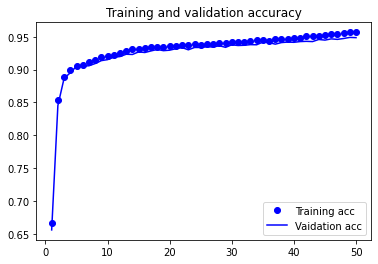

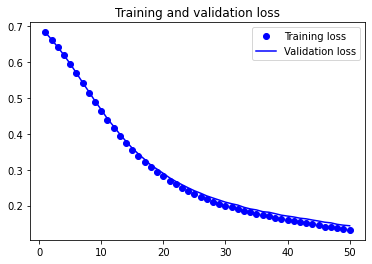

f1-score :  0.7637795275590551
precision :  0.7775551102204409
recall :  0.7504835589941973
accuracy :  0.9193277310924369
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2458
           1       0.78      0.75      0.76       517

    accuracy                           0.92      2975
   macro avg       0.86      0.85      0.86      2975
weighted avg       0.92      0.92      0.92      2975

[[2347  111]
 [ 129  388]]



/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:52: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_test

Evaluating on Hindi-Persian
f1-score :  0.6723404255319149
precision :  0.79
recall :  0.5851851851851851
accuracy :  0.9416666666666667
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1185
           1       0.79      0.59      0.67       135

    accuracy                           0.94      1320
   macro avg       0.87      0.78      0.82      1320
weighted avg       0.94      0.94      0.94      1320

[[1164   21]
 [  56   79]]



/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:80: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_test

Evaluating on English-French
f1-score :  0.7912932138284251
precision :  0.7744360902255639
recall :  0.8089005235602095
accuracy :  0.9015105740181268
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1273
           1       0.77      0.81      0.79       382

    accuracy                           0.90      1655
   macro avg       0.86      0.87      0.86      1655
weighted avg       0.90      0.90      0.90      1655

[[1183   90]
 [  73  309]]



/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:80: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_test

Training and evaluating on Hindi-Persian
epoch 0
                    Train set - loss: 0.742, accuracy: 0.128 
                    Val set - loss: 0.743, accuracy: 0.122
epoch 100
                    Train set - loss: 0.712, accuracy: 0.281 
                    Val set - loss: 0.713, accuracy: 0.282
epoch 200
                    Train set - loss: 0.683, accuracy: 0.602 
                    Val set - loss: 0.682, accuracy: 0.604
epoch 300
                    Train set - loss: 0.654, accuracy: 0.825 
                    Val set - loss: 0.654, accuracy: 0.831
epoch 400
                    Train set - loss: 0.626, accuracy: 0.889 
                    Val set - loss: 0.626, accuracy: 0.892
epoch 500
                    Train set - loss: 0.597, accuracy: 0.897 
                    Val set - loss: 0.596, accuracy: 0.898
epoch 600
                    Train set - loss: 0.569, accuracy: 0.898 
                    Val set - loss: 0.569, accuracy: 0.898
epoch 700
                    Train set - lo

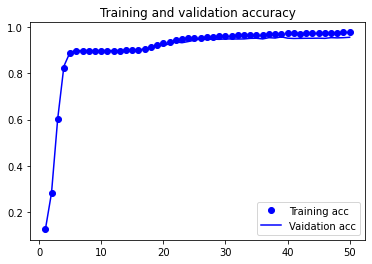

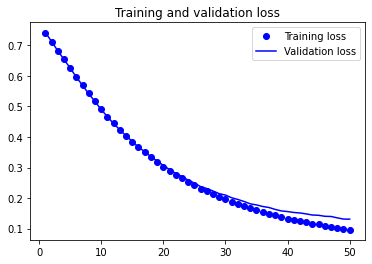

f1-score :  0.7360594795539034
precision :  0.7388059701492538
recall :  0.7333333333333333
accuracy :  0.9462121212121212
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1185
           1       0.74      0.73      0.74       135

    accuracy                           0.95      1320
   macro avg       0.85      0.85      0.85      1320
weighted avg       0.95      0.95      0.95      1320

[[1150   35]
 [  36   99]]



/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_te

Training and evaluating on English-French
epoch 0
                    Train set - loss: 0.726, accuracy: 0.153 
                    Val set - loss: 0.727, accuracy: 0.145
epoch 100
                    Train set - loss: 0.709, accuracy: 0.246 
                    Val set - loss: 0.712, accuracy: 0.228
epoch 200
                    Train set - loss: 0.691, accuracy: 0.469 
                    Val set - loss: 0.697, accuracy: 0.425
epoch 300
                    Train set - loss: 0.673, accuracy: 0.726 
                    Val set - loss: 0.68, accuracy: 0.658
epoch 400
                    Train set - loss: 0.653, accuracy: 0.867 
                    Val set - loss: 0.661, accuracy: 0.811
epoch 500
                    Train set - loss: 0.631, accuracy: 0.921 
                    Val set - loss: 0.642, accuracy: 0.858
epoch 600
                    Train set - loss: 0.606, accuracy: 0.941 
                    Val set - loss: 0.621, accuracy: 0.878
epoch 700
                    Train set - lo

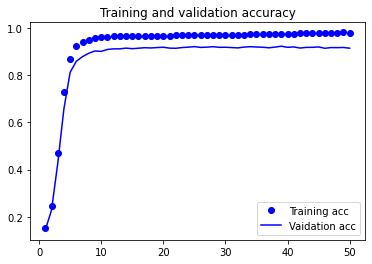

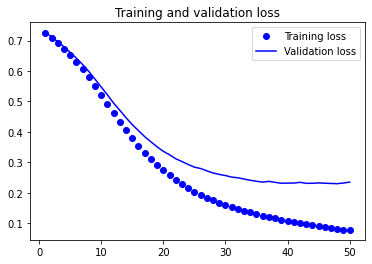

f1-score :  0.7896879240162823
precision :  0.819718309859155
recall :  0.7617801047120419
accuracy :  0.9063444108761329
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1273
           1       0.82      0.76      0.79       382

    accuracy                           0.91      1655
   macro avg       0.87      0.86      0.86      1655
weighted avg       0.90      0.91      0.91      1655

[[1209   64]
 [  91  291]]



/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_te

Evaluating on realdist splits

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)
epoch 0
                    Train set - loss: 0.692, accuracy: 0.532 
                    Val set - loss: 0.693, accuracy: 0.507
epoch 100
                    Train set - loss: 0.673, accuracy: 0.764 
                    Val set - loss: 0.671, accuracy: 0.778
epoch 200
                    Train set - loss: 0.653, accuracy: 0.857 
                    Val set - loss: 0.652, accuracy: 0.857
epoch 300
                    Train set - loss: 0.632, accuracy: 0.882 
                    Val set - loss: 0.63, accuracy: 0.879
epoch 400
                    Train set - loss: 0.608, accuracy: 0.891 
                    Val set -

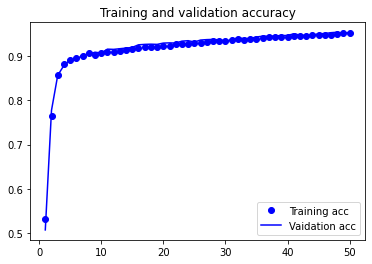

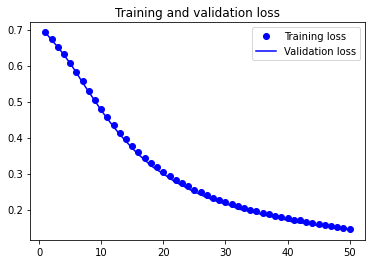

f1-score :  0.9182643794147326
precision :  0.959915611814346
recall :  0.8800773694390716
accuracy :  0.9155370177267987
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       442
           1       0.96      0.88      0.92       517

    accuracy                           0.92       959
   macro avg       0.92      0.92      0.92       959
weighted avg       0.92      0.92      0.92       959

[[423  19]
 [ 62 455]]



/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:52: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_test

Evaluating on Hindi-Persian
f1-score :  0.8774703557312254
precision :  0.940677966101695
recall :  0.8222222222222222
accuracy :  0.9311111111111111
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       315
           1       0.94      0.82      0.88       135

    accuracy                           0.93       450
   macro avg       0.93      0.90      0.91       450
weighted avg       0.93      0.93      0.93       450

[[308   7]
 [ 24 111]]



/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:80: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_test

Evaluating on English-French
f1-score :  0.9322493224932249
precision :  0.9662921348314607
recall :  0.900523560209424
accuracy :  0.9017681728880157
              precision    recall  f1-score   support

           0       0.75      0.91      0.82       127
           1       0.97      0.90      0.93       382

    accuracy                           0.90       509
   macro avg       0.86      0.90      0.88       509
weighted avg       0.91      0.90      0.90       509

[[115  12]
 [ 38 344]]



/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:80: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_test

Training and evaluating on Hindi-Persian
epoch 0
                    Train set - loss: 0.698, accuracy: 0.627 
                    Val set - loss: 0.698, accuracy: 0.623
epoch 100
                    Train set - loss: 0.67, accuracy: 0.694 
                    Val set - loss: 0.67, accuracy: 0.686
epoch 200
                    Train set - loss: 0.644, accuracy: 0.703 
                    Val set - loss: 0.644, accuracy: 0.697
epoch 300
                    Train set - loss: 0.617, accuracy: 0.709 
                    Val set - loss: 0.616, accuracy: 0.708
epoch 400
                    Train set - loss: 0.59, accuracy: 0.736 
                    Val set - loss: 0.587, accuracy: 0.736
epoch 500
                    Train set - loss: 0.563, accuracy: 0.806 
                    Val set - loss: 0.561, accuracy: 0.801
epoch 600
                    Train set - loss: 0.536, accuracy: 0.879 
                    Val set - loss: 0.532, accuracy: 0.888
epoch 700
                    Train set - loss:

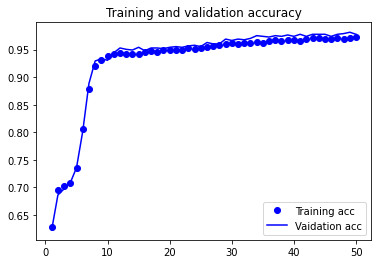

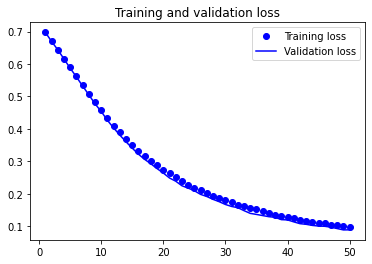

f1-score :  0.9044117647058824
precision :  0.8978102189781022
recall :  0.9111111111111111
accuracy :  0.9422222222222222
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       315
           1       0.90      0.91      0.90       135

    accuracy                           0.94       450
   macro avg       0.93      0.93      0.93       450
weighted avg       0.94      0.94      0.94       450

[[301  14]
 [ 12 123]]



/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_te

Training and evaluating on English-French
epoch 0
                    Train set - loss: 0.712, accuracy: 0.426 
                    Val set - loss: 0.712, accuracy: 0.438
epoch 100
                    Train set - loss: 0.689, accuracy: 0.571 
                    Val set - loss: 0.688, accuracy: 0.572
epoch 200
                    Train set - loss: 0.667, accuracy: 0.68 
                    Val set - loss: 0.667, accuracy: 0.663
epoch 300
                    Train set - loss: 0.643, accuracy: 0.8 
                    Val set - loss: 0.644, accuracy: 0.775
epoch 400
                    Train set - loss: 0.62, accuracy: 0.868 
                    Val set - loss: 0.619, accuracy: 0.868
epoch 500
                    Train set - loss: 0.594, accuracy: 0.902 
                    Val set - loss: 0.593, accuracy: 0.907
epoch 600
                    Train set - loss: 0.568, accuracy: 0.915 
                    Val set - loss: 0.568, accuracy: 0.916
epoch 700
                    Train set - loss:

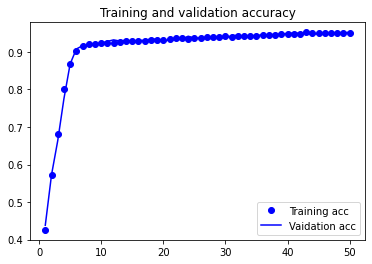

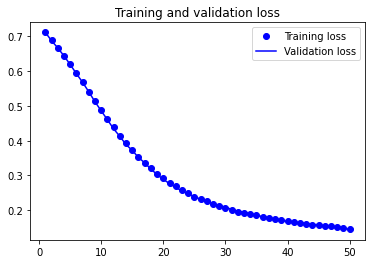

f1-score :  0.9202797202797203
precision :  0.987987987987988
recall :  0.8612565445026178
accuracy :  0.888015717092338
              precision    recall  f1-score   support

           0       0.70      0.97      0.81       127
           1       0.99      0.86      0.92       382

    accuracy                           0.89       509
   macro avg       0.84      0.91      0.87       509
weighted avg       0.92      0.89      0.89       509

[[123   4]
 [ 53 329]]



/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_te

Evaluating on balanced splits

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)
epoch 0
                    Train set - loss: 0.696, accuracy: 0.467 
                    Val set - loss: 0.696, accuracy: 0.454
epoch 100
                    Train set - loss: 0.677, accuracy: 0.711 
                    Val set - loss: 0.676, accuracy: 0.734
epoch 200
                    Train set - loss: 0.658, accuracy: 0.831 
                    Val set - loss: 0.656, accuracy: 0.847
epoch 300
                    Train set - loss: 0.637, accuracy: 0.869 
                    Val set - loss: 0.634, accuracy: 0.871
epoch 400
                    Train set - loss: 0.615, accuracy: 0.883 
                    Val set 

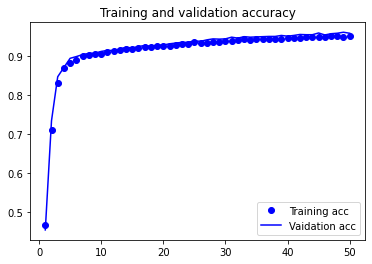

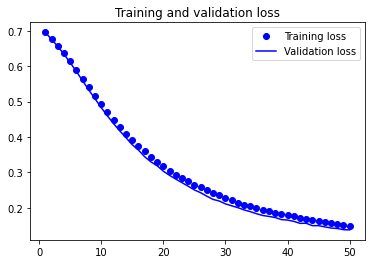

f1-score :  0.9424823410696266
precision :  0.9852320675105485
recall :  0.9032882011605415
accuracy :  0.9193776520509194
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       190
           1       0.99      0.90      0.94       517

    accuracy                           0.92       707
   macro avg       0.89      0.93      0.90       707
weighted avg       0.93      0.92      0.92       707

[[183   7]
 [ 50 467]]



/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:52: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_test

Evaluating on Hindi-Persian
f1-score :  0.933852140077821
precision :  0.9836065573770492
recall :  0.8888888888888888
accuracy :  0.9372693726937269
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       136
           1       0.98      0.89      0.93       135

    accuracy                           0.94       271
   macro avg       0.94      0.94      0.94       271
weighted avg       0.94      0.94      0.94       271

[[134   2]
 [ 15 120]]



/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:80: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_test

Evaluating on English-French
f1-score :  0.9455040871934605
precision :  0.9857954545454546
recall :  0.9083769633507853
accuracy :  0.908256880733945
              precision    recall  f1-score   support

           0       0.58      0.91      0.71        54
           1       0.99      0.91      0.95       382

    accuracy                           0.91       436
   macro avg       0.78      0.91      0.83       436
weighted avg       0.94      0.91      0.92       436

[[ 49   5]
 [ 35 347]]



/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:80: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_test

Training and evaluating on Hindi-Persian
epoch 0
                    Train set - loss: 0.706, accuracy: 0.484 
                    Val set - loss: 0.705, accuracy: 0.494
epoch 100
                    Train set - loss: 0.684, accuracy: 0.524 
                    Val set - loss: 0.682, accuracy: 0.556
epoch 200
                    Train set - loss: 0.663, accuracy: 0.616 
                    Val set - loss: 0.662, accuracy: 0.603
epoch 300
                    Train set - loss: 0.64, accuracy: 0.718 
                    Val set - loss: 0.64, accuracy: 0.713
epoch 400
                    Train set - loss: 0.618, accuracy: 0.805 
                    Val set - loss: 0.618, accuracy: 0.816
epoch 500
                    Train set - loss: 0.593, accuracy: 0.873 
                    Val set - loss: 0.593, accuracy: 0.868
epoch 600
                    Train set - loss: 0.569, accuracy: 0.901 
                    Val set - loss: 0.569, accuracy: 0.886
epoch 700
                    Train set - loss

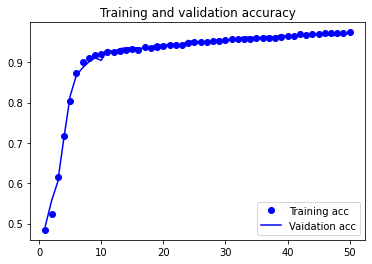

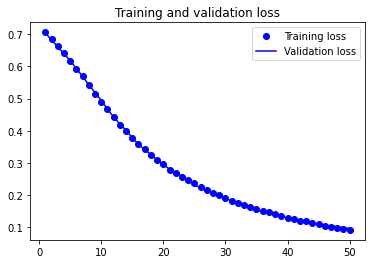

f1-score :  0.9402985074626865
precision :  0.9473684210526315
recall :  0.9333333333333333
accuracy :  0.940959409594096
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       136
           1       0.95      0.93      0.94       135

    accuracy                           0.94       271
   macro avg       0.94      0.94      0.94       271
weighted avg       0.94      0.94      0.94       271

[[129   7]
 [  9 126]]



/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_te

Training and evaluating on English-French
epoch 0
                    Train set - loss: 0.678, accuracy: 0.731 
                    Val set - loss: 0.678, accuracy: 0.738
epoch 100
                    Train set - loss: 0.656, accuracy: 0.877 
                    Val set - loss: 0.659, accuracy: 0.872
epoch 200
                    Train set - loss: 0.635, accuracy: 0.903 
                    Val set - loss: 0.637, accuracy: 0.902
epoch 300
                    Train set - loss: 0.615, accuracy: 0.908 
                    Val set - loss: 0.618, accuracy: 0.907
epoch 400
                    Train set - loss: 0.594, accuracy: 0.911 
                    Val set - loss: 0.595, accuracy: 0.91
epoch 500
                    Train set - loss: 0.572, accuracy: 0.915 
                    Val set - loss: 0.573, accuracy: 0.919
epoch 600
                    Train set - loss: 0.549, accuracy: 0.916 
                    Val set - loss: 0.55, accuracy: 0.909
epoch 700
                    Train set - los

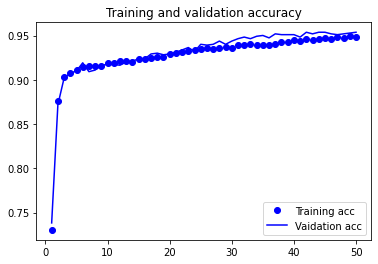

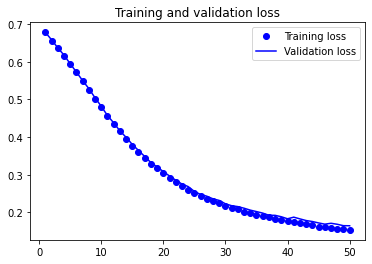

f1-score :  0.9318497913769124
precision :  0.9940652818991098
recall :  0.8769633507853403
accuracy :  0.8876146788990825
              precision    recall  f1-score   support

           0       0.53      0.96      0.68        54
           1       0.99      0.88      0.93       382

    accuracy                           0.89       436
   macro avg       0.76      0.92      0.81       436
weighted avg       0.94      0.89      0.90       436

[[ 52   2]
 [ 47 335]]



/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
/var/folders/xr/f9q8dphs5vq5mhqy843mnkv40000gn/T/ipykernel_59924/769605111.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unq = np.array([x + 2*y for x, y in zip(y_pred, y_te

In [9]:
print("Evaluating on alldata splits\n")
nn_evaluate(train_alldata, test_alldata, pairs)

print("Evaluating on realdist splits\n")
nn_evaluate(train_realdist, test_realdist, pairs)

print("Evaluating on balanced splits\n")
nn_evaluate(train_balanced, test_balanced, pairs)